# Определение токсичных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Содержание
1. [Подготовка](#prep)
2. [Обучение](#train)
3. [Выводы](#conc)

# Загрузка и импорт необходимых библиотек

In [7]:
%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [8]:
import nltk

In [9]:
# common
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# pipeline & preprocessing
from sklearn.pipeline import Pipeline
import torch
import transformers
from torch.utils.data import Dataset, DataLoader

from tqdm import notebook

#model selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)


#models
from sklearn.linear_model import (
    LogisticRegression, 
)

from catboost import CatBoostClassifier

#metrics
from sklearn.metrics import (
    f1_score
)

In [10]:
RANDOM_STATE = 42
torch.cuda.is_available()

True

## Подготовка <a id='prep'>

In [11]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [12]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [13]:
df = df.reset_index(drop=True)

Так как мы используем BERT, то лемматизировать наши тексты не нужно

In [14]:
df['text'].duplicated().sum()

0

Дубликатов нет

In [15]:
def fmt(x): #func to determine labels on pie plot
    return '{:.1f}%\n{:.2f}'.format(x, total * x / 100)

In [16]:
def print_pie_bar(df):
    for col in df.columns:
        print(df[col].describe())
        ax = sns.countplot(x=df[col], order=df[col].value_counts().index)
        for rect in ax.patches:
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.75,rect.get_height(), horizontalalignment='center', fontsize=11)
        plt.ylabel('Количество')
        plt.xlabel('Значение')
        plt.title('Столбчатая диаграмма признака ' + col)
        ax.tick_params(axis='x', labelrotation=90)
        plt.show()
        global total
        total = df[col].count()
        df[col].value_counts().plot(kind='pie', autopct=fmt)
        plt.title('Круговая диаграмма признака ' + col)
        plt.ylabel('')
        plt.show()

count    159292.000000
mean          0.101612
std           0.302139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64


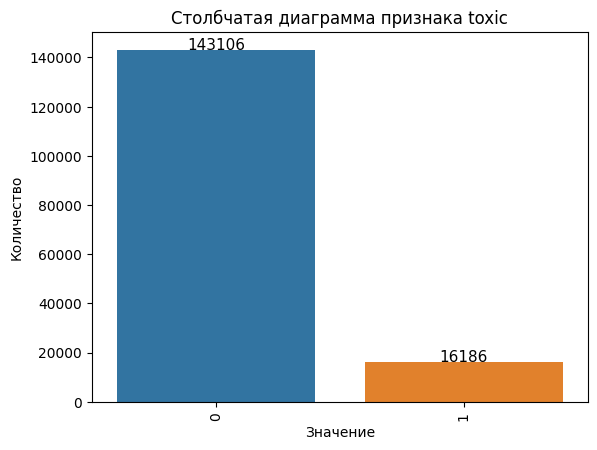

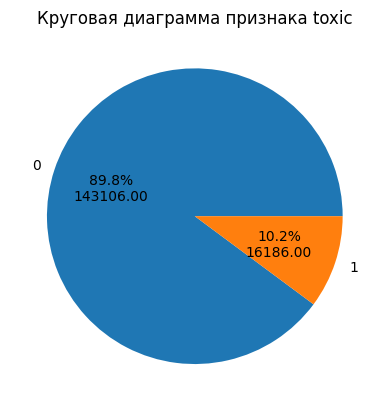

In [17]:
print_pie_bar(df['toxic'].to_frame())

Видим явный дисбаланс классов, но с учетом того, что объектов класса 1 немало, то попробуем оставить как есть 

Как было сказано выше, так как мы используем BERT, то лемматизация не требуется. Токенизацию проведем в следующем пункте

## Обучение <a id='train'>

In [18]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Maxim\anaconda3\envs\practicum\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Здесь возьмем toxic bert, потому что эта модель подойдет лучше всех, потому что в нашей задаче требуется как раз классифицировать токсичные комментарии

In [19]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Определим собственный класс `CustomDataset`, унаследованный от `Dataset` и переопределим в нем методы `__len__` и `__getitem__`. Сделаем это для комфортного использвования `DataLoader`. После чего перенесем выполнение на GPU  

In [20]:
class CustomDataset(Dataset):
    
    def __init__(self, X):
        self.texts = X

    def tokenize(self, text):
        return tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=510)

    def __len__(self):
        return self.texts.shape[0]

    def __getitem__(self, index):
        output = self.tokenize(self.texts[index])
        return {k: v.reshape(-1) for k, v in output.items()}


eval_ds = CustomDataset(df['text'])
eval_dl = DataLoader(eval_ds, batch_size=128)

In [21]:
def calc_mask(model_output, attention_mask):
    token_embeddings = model_output['last_hidden_state']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [22]:
model.to(device)
model.eval()

embeddings = torch.Tensor().to(device)

with torch.no_grad():
    for n_batch, batch in enumerate(notebook.tqdm(eval_dl)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        embeddings = torch.cat([embeddings, calc_mask(outputs, batch['attention_mask'])])
    embeddings = embeddings.cpu().numpy()

  0%|          | 0/1245 [00:00<?, ?it/s]

In [50]:
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, random_state=RANDOM_STATE)

In [51]:
pipe = Pipeline(
    [
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [52]:
param_grid = [
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=10)],
        'models__learning_rate':  [0.1],
        'models__max_depth': [8],
        'models__n_estimators': [500], 
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 0.5]
    }
]

In [53]:
gs = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1
)

In [54]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostClassifier object at 0x00000237B3B436D0>],
                          'models__learning_rate': [0.1],
                          'models__max_depth': [8],
                          'models__n_estimators': [500]},
                         {'models': [LogisticRegression(random_state=42)],
                          'models__C': [0.1, 1, 0.5]}],
             scoring='f1')

In [55]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__learning_rate,param_models__max_depth,param_models__n_estimators,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,542.792657,2.170160,0.653423,0.273964,<catboost.core.CatBoostClassifier object at 0x...,0.1,8,500,NaN,{'models': <catboost.core.CatBoostClassifier o...,0.944536,0.942999,0.944020,0.945440,0.931084,0.941616,0.005325,4
1,53.894012,10.090128,27.666647,14.368927,LogisticRegression(random_state=42),NaN,NaN,NaN,0.1,{'models': LogisticRegression(random_state=42)...,0.950393,0.946890,0.946125,0.950217,0.937641,0.946253,0.004635,1
2,86.735772,35.681543,3.358276,1.678311,LogisticRegression(random_state=42),NaN,NaN,NaN,1,{'models': LogisticRegression(random_state=42)...,0.949432,0.945191,0.943802,0.949432,0.934406,0.944453,0.005505,3
3,76.224144,18.605276,9.288303,17.244934,LogisticRegression(random_state=42),NaN,NaN,NaN,0.5,{'models': LogisticRegression(random_state=42)...,0.947934,0.947499,0.943365,0.950083,0.937126,0.945201,0.004586,2


In [56]:
gs.best_params_

{'models': LogisticRegression(random_state=42), 'models__C': 0.1}

In [57]:
gs.best_score_

0.946253224060737

In [58]:
f1_score(y_test, gs.predict(X_test))

0.9437646768013842

Тут можно обучить побольше моделей или поподбирать побольше гиперпараметров, но с BERT даже в сравнении на двух моделях показал очень хорошие результаты, плюс бустинг обучается оочень долго, поэтому я попробовал разные гиперпараметры, но оставил в прекоде по одному гиперпараметру на бустинг

Получили значние метрики f1-score 0.9461 при кросс-валидации и 0.9452 на тестовой выборке - при кросс валидации такое допустимо. Лучшая модель - логистическая регрессия

## Выводы <a id='conc'>

В данном прокте был проведет анализ комментариев на токсичность. <br>
Предобработка данным не понадобилась, за исключением переопределения индекса <br>
Для построения эмбеддингов и векторизации текстов была применена BERT, поэтому был написан собсвенный класс, а также цикл для токенизации текстов <br>
Были обучены несколько модей: <br>
Получили значние метрики f1-score 0.9461 при кросс-валидации и 0.9452 на тестовой выборке - при кросс валидации такое допустимо. Лучшая модель - логистическая регрессия